In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Exercise 1 Linear quadratic regulator
### 1.1
Write a class which:
- Can be initialised with the matrices specifying the LQR problem and T > 0.
- Has a method which will solve (approximate) the associated Ricatti ODE on a time grid which is an input (numpy array or torch tensor).
- Has a method that, given one torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size × 1 × 2 (for space), will return a torch tensor of dimension batch size × 1 with entries being the control problem value v(t, x) for each t, x in the batch (for x two dimensional).
- Has a method that, given one torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size × 1 × 2 (for space), will return a torch tensor of dimension batch size × 2 with entries being the Markov control function for each t, x in the batch (for x two dimensional).

In [ ]:
#define the function to solve Ricatti ODE
def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    #This is the constructor method that initializes the LQR object with the necessary parameters.
    #H, M, sigma, C, R, D, and T are all input parameters to the constructor method.
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        #This method computes the solution to the matrix Riccati differential equation
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        #This method computes the value function for a given set of times and data.
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        #This method computes the optimal control input for a given set of times ts and data data.
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        #This method runs a Monte Carlo simulation to estimate the expected total cost from a given time to the final time T.
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [15]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [5]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [6]:
print(t.shape)

(10,)


In [6]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [7]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

### 1.2
We can choose MSE for error measure and we write following codes to show log-log plot.

Run a Monte Carlo simulation of the system with the optimal solution you have obtained

### 1.2.2

In [ ]:


# Set number of Monte Carlo samples
num_samples = 10000

# Set different numbers of time steps to simulate
num_steps_list = [1, 10, 50, 100, 500, 1000, 5000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


### 1.2.3

In [ ]:
# Set number of Monte Carlo samples
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

# Set different numbers of time steps to simulate
num_steps = 5000

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


## Exercise 2 Supervised learning, checking the NNs are good enough

In [16]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

class DGM_Layer(nn.Module):
    """ 
    Defines a PyTorch module DGM_Layer which implements a single layer of a deep gated network.
    The activation parameter specifies the activation function to be used in the layer
    """
    def __init__(self, dim_x, dim_S, activation='Tanh'):


        super(DGM_Layer, self).__init__()
        

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            
        
        # The module has four gates
        # Z gate (update gate): controls how much of the previous state to keep and how much of the new input to include in the current state. 
        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        # G gate (reset gate): controls how much of the previous state to forget and how much of the new input to remember. 
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        # R gate (reset signal): controls how much of the input to use to modify the current state.
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        # H gate (hidden state): produces a candidate hidden state that can be added to the current state. 
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    


    def forward(self, x, S):
        # concatenates  input 'x' and the hidden state 'S' along the feature dimension
        x_S = torch.cat([x,S],1)
        
        
        # passes the concatenated tensor through each of the four gates. 
        Z = self.gate_Z(x_S) # how much of the new state to keep
        G = self.gate_G(x_S) # how much proportion of the previous state to keep
        R = self.gate_R(x_S) # the proportion of the input to use to modify the current state.

        
        input_gate_H = torch.cat([x, S*R],1) # 'R*S' is modified state
        H = self.gate_H(input_gate_H)  #  candidate hidden state, and is the amount of information from the current input to add to the new state

        
        # The resulting tensors are then combined to compute the new hidden state S for the next time step, which is returned as output.
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        """
        dim_x is the dimension of the input tensor,
        dim_S is the number of hidden units in each of the three DGM_Layer objects,
        activation is the activation function used in the hidden layers, which can be ReLU, Tanh, Sigmoid, or LogSigmoid.
        The constructor initializes the class variables using the arguments, and creates the layers of the neural network.
        """
        super(Net_DGM, self).__init__()
      
        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)
        # The input_layer is a linear layer followed by an activation function, which takes a concatenation of t and x as input
        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        """
        DGM1, DGM2, and DGM3 are three layers of the Deep Gaussian Process (DGP) model. 
        They are initialized with 
        dim_x+1 as input dimension (where the +1 accounts for the time input t), 
        dim_S as output dimension, and the activation function specified in the constructor.
        """
        self.output_layer = nn.Linear(dim_S, 1)
        # The output_layer is a linear layer that takes the output from the last DGM layer as input and produces a single output value.
        
    def forward(self,t,x):
        # The forward method defines the forward pass of the neural network, which takes two input tensors t and x and returns a single output tensor.
        # t and x are concatenated along the second dimension using torch.cat to create a single input tensor.
        tx = torch.cat([t,x], 1)

        # This input tensor is then passed through the input_layer to obtain S1, which is then passed through DGM1, DGM2, and DGM3 to obtain S4.
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)

        # Finally, S4 is passed through the output_layer to obtain the output of the neural network, which is returned.
        output = self.output_layer(S4)
        return output


      
        

### Exercise 2.1

In [11]:
T = 1 # time horizon
hidden_size = 100 # hidden layer size = 100
lr = 0.01 # the learning rate for the optimizer
num_epochs = 10000 # the number of iterations the optimizer will perform to train the neural network

net = Net_DGM(2, hidden_size)
# neural network is defined using the Net_DGM class with input dimension of 2 

optimizer = optim.Adam(net.parameters(), lr=lr)
# initializes the Adam optimizer with the learning rate lr and the parameters of the neural network net. 
# The net.parameters() method returns an iterable of all the trainable parameters in the neural network net. 

criterion = nn.MSELoss()
# The mean squared error (MSE) loss function is defined using the nn.MSELoss() class.

losses = [] # empty list prepared for value of the loss
for epoch in tqdm(range(num_epochs)):
    #  t is a randomly selected value between 0 and T, which can be used as a time parameter for some stochastic process.
    t = np.random.uniform(0, T)
    # Two random numbers between -3 and 3 are generated and stored in the list x
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    # An LQR object is created
    lqr = LQR(H, M, sigma, C, R, D, 1)

    # true value of the solution to the LQR problem
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    # optimizer's gradient is reset to zero
    optimizer.zero_grad()
    # predict the value of the solution to the LQR problem at time t and state x
    y_pred = net(torch.tensor([[t]], dtype=torch.float32), torch.tensor([x]))

    # The MSE loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)

    # gradients of the neural network's parameters
    loss.backward()
    # optimizer takes a step in the negative direction of the gradients
    optimizer.step()

    losses.append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/30/5npdvf4d7mb7d1df8ndd9dmm0000gn/T/ipykernel_22462/2836287028.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
100%|██████████| 10000/10000 [01:01<00:00, 161.38it/s]


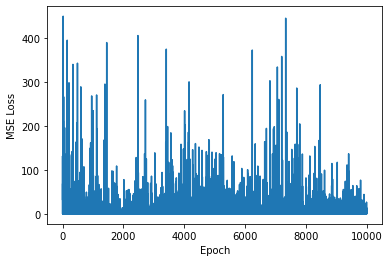

In [12]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

### Exercise 2.2

In [13]:
class FFN(nn.Module):
    """ 
    define a fully-connected feed-forward neural network.
    sizes: a list of integers specifying the number of neurons in each layer of the neural network.
    activation: an activation function to apply between hidden layers. By default, the ReLU activation function is used.
    output_activation: an activation function to apply to the output layer. By default, the identity function is used.
    batch_norm: a boolean flag indicating whether or not to apply batch normalization between layers. By default, this flag is set to False.
    """

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    


    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    """ 
    used to freeze and unfreeze the weights of the neural network, respectively. 
    When the weights are frozen, their gradients are not computed during backpropagation, effectively making them untrainable. 
    When the weights are unfrozen, their gradients are computed during backpropagation and the weights can be trained.
    """


    def forward(self, x):
        return self.net(x)
        # method is used to define the forward pass of the neural network. 
        # The output tensor of the last layer is returned as the output of the neural network.

In [ ]:
net = FFN([3, 100, 100, 2]) # A feedforward neural network is defined
optimizer = optim.Adam(net.parameters(), lr=lr) # Adam optimizer is defined with the learning rate specified
criterion = nn.MSELoss() # A mean squared error loss function is defined.

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]

    # obtain the true value of the output at time t given the initial state x.
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))

    # reset the gradients in the optimizer to zero
    optimizer.zero_grad()

    # Concatenate two tensors horizontally and pass through the neural network in a single operation
    # ensure that the values of t and x are processed together by the neural network, rather than separately.
    tx = torch.cat([torch.tensor([[t]], dtype=torch.float32), torch.tensor([x])], 1)
    # use the neural network to predict the value of the solution to the LQR problem at time 't' and state 'x'
    y_pred = net(tx)

    # loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)
    # gradients of the neural network's parameters
    loss.backward()

    # update the model parameters to optimize the model parameters such that the loss function is minimized.
    optimizer.step()
    losses.append(loss.item())

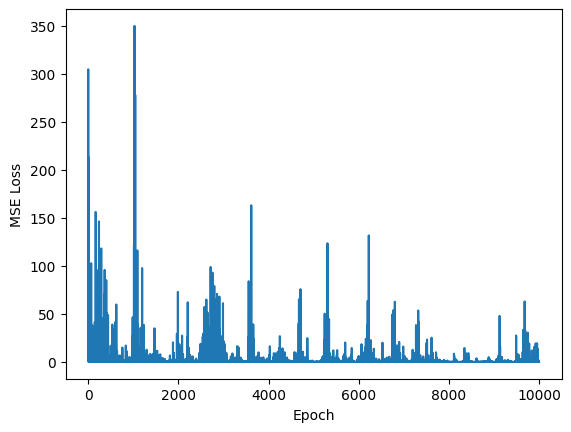

In [9]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Exercise 3 Deep Galerkin approximation for a linear PDE

In [17]:
def get_gradient(output, x):
    """ 
    The function takes two arguments: output and x, which are both PyTorch tensors.
    'output': This is the tensor that we want to compute the gradient of.
    'x': This is the tensor with respect to which we want to compute the gradient.
    """ 
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    # returns the computed gradient tensor.
    return grad

def get_laplacian(grad, x):
    """
    The function takes two arguments: grad and x, which are both PyTorch tensors.
    'grad' represents the gradient tensor of some function with respect to x.
    'x' represents the tensor with respect to which we want to compute the Laplacian of the function.
    """
    hess = [] # empty list hess that will store the Hessian matrix for each dimension of x.
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1) # This is a tensor that represents the gradient of a single component of grad with respect to x.
        # calculate the Hessian matrices for each dimension of x, using torch.ones_like(v) to initialize the gradients to a tensor of ones with the same shape as the gradient tensor.
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess.append(grad2)
    return torch.cat(hess, 1)

class PDE_DGM(nn.Module):
    """ 
    Defines a PyTorch module called PDE_DGM, which stands for "partial differential equation deep Galerkin method". 
    This module is used to solve partial differential equations (PDEs) using deep learning.
    """
    def __init__(self, d: int, hidden_dim: int, H, M, sigma, C, R, D, ts: torch.Tensor=None, device: str='cpu'):
        # d: an integer representing the dimensionality of the PDE.
        # hidden_dim: an integer representing the number of hidden units in the neural network.
        # H, M, sigma, C, R, D: tensors representing the coefficients of the PDE.
        # ts: a tensor representing the time points at which the PDE should be solved.
        # device: a string representing the device (e.g., "cpu" or "cuda") on which to perform the computations.
        super().__init__()
        self.d = d 
        self.net_dgm = Net_DGM(d, hidden_dim, activation='Tanh')
        self.H = torch.tensor(H, device=device)
        self.M = torch.tensor(M, device=device)
        self.sigma = torch.tensor(sigma, device=device)
        self.C = torch.tensor(C, device=device)
        self.R = torch.tensor(R, device=device)
        self.D = torch.tensor(D, device=device)
        self.alpha = torch.tensor([[1], [1]], device=device)
        self.ts = ts

    def fit(self, max_updates: int, batch_size: int, device):
        """ 
        The fit method performs gradient descent on the neural network parameters 
        to minimize the mean squared error (MSE) between the predicted solution to the PDE and the actual solution.
        """
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,),gamma=0.1)
        loss_fn = nn.MSELoss()
    
        pbar = tqdm(total=max_updates) # initializes a new progress bar with a maximum number of updates specified by max_updates. 
        
        loss_value = []

        # generates a random set of input points in the domain of the PDE, 
        # and evaluates the neural network at these points to obtain an approximate solution to the PDE.
        for it in range(max_updates):
            optimizer.zero_grad() # set all to zero
            # generates a random tensor of shape (batch_size, self.d) with elements drawn uniformly from the range [-3, 3). 
            # ensures that the elements of the tensor are centered around zero
            input_domain = 6 * torch.rand(batch_size, self.d, device=device, requires_grad=True) - 3
            t0, T = self.ts[0], self.ts[-1] # time domain for the problem is defined by the range between t0 and T.
            # generates a tensor of random numbers between 0 and 1 of shape (batch_size, 1) and assigns it to t. 
            t = t0 + T*torch.rand(batch_size, 1, device=device, requires_grad=True)

            # t_T is a tensor of shape (batch_size, 1) containing the value of T for each batch element.
            t_T = torch.ones(batch_size, 1, device=device) * T 

            # outputs of the neural network at t and T
            u_of_tx = self.net_dgm(t, input_domain)
            u_of_Tx = self.net_dgm(t_T, input_domain)

            # the gradients of the neural network outputs with respect to the inputs 'input_domain' and 't'
            grad_u_x = get_gradient(u_of_tx,input_domain)
            grad_u_t = get_gradient(u_of_tx, t)

            laplacian = get_laplacian(grad_u_x, input_domain)

            # a target in the loss calculation for the PDE equation and boundary conditions
            target = torch.zeros_like(u_of_tx)
            R1, R2 = 0, 0
            eqn = []
            boundary = []

            for i in range(laplacian.shape[0]):
                x = laplacian[i]
                temp_x = x.cpu().detach().numpy().reshape(2,2)
                x_i = input_domain[i].cpu().detach().numpy()
                grad_u_x_i = grad_u_x[i].cpu().detach().numpy()
                alpha_np = self.alpha.cpu().numpy()
                # for each sample in the batch, computes the temporary value for the PDE by evaluating the equation
                temp_value = abs(grad_u_t[i].cpu().detach().numpy()
                         + 1/2*np.trace(self.sigma.cpu().numpy() @ self.sigma.cpu().numpy().T @ temp_x)
                         + grad_u_x_i.T @ self.H.cpu().numpy() @ x_i
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + x_i.T @ self.C.cpu().numpy() @ x_i
                         + alpha_np.T @ self.D.cpu().numpy() @ alpha_np
                        )**2
                # appends this residual value to the list eqn.
                eqn.append(temp_value.tolist()[0])

                # computes the temporary value for the boundary condition by evaluating the equation:
                temp_value = abs(u_of_Tx[i].cpu().detach().numpy() - x_i.T @ self.R.cpu().numpy() @ x_i)**2

                # appends this residual value to the list boundary.
                boundary.append(temp_value.tolist()[0])
            
            # lists are converted to PyTorch tensors
            eqn = torch.tensor(eqn, device=device, requires_grad = True)
            boundary = torch.tensor(boundary, device=device, requires_grad = True)
            # loss values are calculated using the mean squared error (MSE) loss function
            MSE_eqn = loss_fn(eqn, target) # the loss for the PDE equation
            MSE_boundary = loss_fn(boundary, target) # the loss for the boundary conditions

            loss = MSE_eqn + MSE_boundary # total loss
            loss_value.append(loss.cpu().detach().item()) # stores the loss value in a list.
            # computes the gradients of the loss with respect to all the learnable parameters in the neural network.
            loss.backward()

            # updates the weights of the network using the gradients computed in the previous step.
            optimizer.step()
            # updates the learning rate of the optimizer.
            scheduler.step()
            if it%10 == 0:
                # update the progress bar (pbar) every 10 iterations and printing the current iteration number
                pbar.update(10) 
                pbar.write("Iteration: {}/{}\t MSE eqn: {:.4f}\t MSE boundary: {:.4f}\t Total Loss: {:.4f}".format(it, max_updates, MSE_eqn.item(), MSE_boundary.item(), loss.item()))
                
        plt.plot(loss_value, '-')
        plt.xlabel('Updates')
        plt.ylabel('MSE Loss')
        plt.show()

In [18]:
def train(T,
        n_steps,
        d,
        hidden_dim,
        max_updates,
        batch_size, 
        base_dir,
        device,
        ):
    """ 
    'T' is the maximum value of t
    'n_steps' is the number of discrete points between 0 and T at which the function is sampled.
    'd' is the dimension of the input space.
    'hidden_dim' is the number of hidden units in the neural network.
    'max_updates' is the maximum number of training steps to perform.
    'batch_size' is the number of samples in each batch.
    'base_dir' is the directory to save the trained model and log files.
    'device' is the device on which to perform the computation (e.g., "cpu" or "cuda").
    """
    # create a string that represents the path to the log file in the given directory
    logfile = os.path.join(base_dir, "log.txt")

    # create a tensor ts containing n_steps+1 equally spaced points between 0 and T.
    ts = torch.linspace(0,T,n_steps+1, device=device)

    # create 'PDE_DM' class
    pde_solver = PDE_DGM(d, hidden_dim, H, M, sigma, C, R, D, ts=ts, device=device)
    # move the model to the specified device 
    pde_solver.to(device)

    # calls the fit method of the model to train it
    pde_solver.fit(max_updates=max_updates,
                     batch_size=batch_size, 
                     device=device)
    


In [19]:
def set_seed(seed):
    """ 
    set the seed value for the random number generators
    ensure that the same sequence of random numbers will be generated each time running the code
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
if torch.cuda.is_available():
    # check if a GPU is available for use with PyTorch
    device = "cuda" # device is set to "cuda"
else:
    device="cpu" # if not, it is set to "cpu"

# Sets a random seed
seed = 1
set_seed(seed)
# Defines the path where the results of the training will be saved.
results_path = os.path.join('./numerical_results/', "PDE_DGM", "seed{}".format(seed))
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Calls the train function
train(T=1,
    n_steps=50,
    d=2,
    hidden_dim=100,
    max_updates=5000,
    batch_size=500,
    base_dir=results_path,
    device=device,
    )

## Exercise 4 Policy iteration with DGM

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
from scipy import integrate
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

class DGM_layer(nn.Module):
    """ 
    Define a single DGM layer in the network. It inherits from the nn.Module class in PyTorch.
    """
    def __init__(self, in_features, out_feature, residual = False):
        super(DGM_layer, self).__init__()
        self.residual = residual # a boolean indicating whether or not to use residual connections in the layer.
        
        # The layer contains four linear transformation operations, each transformation consists of a linear layer
        self.Z = nn.Linear(out_feature, out_feature); self.UZ = nn.Linear(in_features, out_feature, bias = False)
        self.G = nn.Linear(out_feature, out_feature); self.UG = nn.Linear(in_features, out_feature, bias = False)
        self.R = nn.Linear(out_feature, out_feature); self.UR = nn.Linear(in_features, out_feature, bias = False)
        self.H = nn.Linear(out_feature, out_feature); self.UH = nn.Linear(in_features, out_feature, bias = False)
        
    def forward(self, x, s):
        """ 
        takes the input x and the previous state s as inputs
        returns the new state after applying the DGM layer transformations.
        the tanh activation function is used to transform the input x and the state s through several linear layers
        """
        #  x and s are passed through linear layers to generate four intermediate tensors 
        z = torch.tanh(self.UZ(x)+self.Z(s))
        g = torch.tanh(self.UG(x)+self.G(s))
        r = torch.tanh(self.UR(x)+self.R(s))
        h = torch.tanh(self.UH(x)+self.H(s))
        return (1-g)*h+z*s  
    
class DGM_Net(nn.Module):
    """ 
    The DGM_Net class is defined as a subclass of nn.Module, which is a PyTorch class for defining neural network modules.
    in_dim: the number of input features
    out_dim: the number of output features
    n_layers: the number of layers in the DGM
    n_neurons: the number of neurons in each layer of the DGM
    residual: a Boolean value indicating whether to use residual connections in the DGM
    """
    def __init__(self, in_dim, out_dim, n_layers, n_neurons, residual = False): 
        super(DGM_Net, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.residual = residual
        
        # a linear layer that maps the input to the number of neurons in the first layer of the DGM
        self.input_layer = nn.Linear(in_dim, n_neurons) 
        # a list of n_layers DGM_layer objects that implement the DGM layer defined earlier
        self.dgm_layers = nn.ModuleList([DGM_layer(self.in_dim, self.n_neurons, self.residual) for i in range(self.n_layers)])
        # a linear layer that maps the output of the last layer of the DGM to the number of output features
        self.output_layer = nn.Linear(n_neurons, out_dim)
    
    def forward(self, x):
        s = torch.tanh(self.input_layer(x))
        # iterate over the DGM layers and apply each layer to the output of the previous layer.
        for i, dgm_layer in enumerate(self.dgm_layers):
            s = dgm_layer(x, s)

            # obtain the final output of the network
        return self.output_layer(s)
    


In [21]:
class Bellman_pde():
    '''
    Approximating the Bellman PDE on [0,T]*[x1_l,x1_r]*[x2_l,x2_r]
    '''
    def __init__(self, net, x_interval, y_interval, H, M, C, D, R, T, sigma, a):
        self.net = net 
        self.x1_l = x_interval[0].item() # torch tensor, dim = 3
        self.x1_r = x_interval[1].item()
        self.x2_l = y_interval[0].item()
        self.x2_r = y_interval[1].item()
        self.H = H # H, M, C, D, R: torch tensors, dim = 2*2
        self.M = M 
        self.C = C 
        self.D = D 
        self.R = R         
        self.T = T # integer
        self.sigma = sigma # sigma, a: torch tensors, dim = 1*2
        self.a = a 
        
    def sample(self, size):
        # this method is used to sample size number of points from the domain of the PDE. 
        t_x = torch.cat((torch.rand([size, 1])*self.T, (self.x1_l - self.x1_r) * torch.rand([size, 1]) + self.x1_r, (self.x2_l - self.x2_r) * torch.rand([size, 1]) + self.x2_r), dim=1)
        x_boundary = torch.cat((torch.ones(size, 1)*self.T, (self.x1_l - self.x1_r) * torch.rand([size, 1]) + self.x1_r, (self.x2_l - self.x2_r) * torch.rand([size, 1]) + self.x2_r), dim=1)     
        return t_x, x_boundary
    
    def mat_ext(self, mat, size):
        # this method used to extend a given matrix to a 3-dimensional tensor of a certain size.
        if mat.shape == torch.Size([2, 2]):
            # returns a 3-dimensional tensor of size "(size, 2, 2)"
            return mat.unsqueeze(0).repeat(size,1,1)
        elif mat.shape == torch.Size([1, 2]):
            # create a 3-dimensional tensor of size (size, 1, 2) 
            return mat.t().unsqueeze(0).repeat(size,1,1)
        
    def get_hessian(self, grad_x, x):
        """ 
        This method calculates the Hessian matrix of a function with respect to its input variables at a given input point x. 
        """
        hessian = torch.zeros(len(x),2,2)
        dxx = torch.autograd.grad(grad_x[0][:,1], x, grad_outputs=torch.ones_like(grad_x[0][:,1]), allow_unused=True, retain_graph=True)[0][:,1]
        dxy = torch.autograd.grad(grad_x[0][:,1], x, grad_outputs=torch.ones_like(grad_x[0][:,1]), allow_unused=True, retain_graph=True)[0][:,2]
        dyx = torch.autograd.grad(grad_x[0][:,2], x, grad_outputs=torch.ones_like(grad_x[0][:,2]), allow_unused=True, retain_graph=True)[0][:,1]
        dyy = torch.autograd.grad(grad_x[0][:,2], x, grad_outputs=torch.ones_like(grad_x[0][:,2]), allow_unused=True, retain_graph=True)[0][:,2]
        hessian[:,0,0] = dxx 
        hessian[:,0,1] = dxy
        hessian[:,1,0] = dyx
        hessian[:,1,1] = dyy
        return hessian  
        
        
    def loss_func(self, size):
        loss = nn.MSELoss() # MSE 
        
        # Extend the input matrices
        H = self.mat_ext(self.H, size) # H, M, C, D, R: dim = batchsize*2*2
        M = self.mat_ext(self.M, size)
        C = self.mat_ext(self.C, size)
        D = self.mat_ext(self.D, size)
        R = self.mat_ext(self.R, size) # control: dim = batchsize*2*1          
        T = self.T
        a = self.a
        sig = self.sigma.t()

        x, x_boundary = self.sample(size=size)
        x = x.requires_grad_(True) # Track gradients during automatic differentiation

        # gradients
        grad = torch.autograd.grad(self.net(x), x, grad_outputs=torch.ones_like(self.net(x)), create_graph=True)
        
        du_dt = grad[0][:,0].reshape(-1, 1)  # derivative w.r.t. time, dim = batchsize*1
        
        du_dx = grad[0][:,1:] # derivative w.r.t. space, dim = batchsize*2 
                
        # Hessian matrix
        hessian = self.get_hessian(grad,x)
        
        # Error from the equation
        sig2_ext = self.mat_ext(torch.matmul(sig,sig.t()), size) # dim = batchsize*2*2
        prod = torch.bmm(sig2_ext,hessian) # sigma*sigma^T*2nd derivatives
        trace = torch.diagonal(prod, dim1=1, dim2=2).sum(dim=1).unsqueeze(0).t() # trace, dim = batchsize*1
        x_space = x[:,1:].unsqueeze(1).reshape(size,2,1) # extract (x1,x2)^T, dim = batchsize*2*1
        x_space_t = x_space.reshape(size,1,2) # dim = batchsize*1*2
        du_dx_ext_t = du_dx.unsqueeze(1) # dim=batchsize*1*2
        
        pde = du_dt+0.5*trace+torch.bmm(du_dx_ext_t,torch.bmm(H,x_space)).squeeze(1)\
                +torch.bmm(du_dx_ext_t,torch.bmm(M,self.a)).squeeze(1)\
                +torch.bmm(x_space_t,torch.bmm(C,x_space)).squeeze(1)\
                +torch.bmm(a.reshape(size,1,2),torch.bmm(D,a)).squeeze(1) # dim = batchsize*1
 
        pde_err = loss(pde, torch.zeros(size,1))
        
        # Error from the boundary condition
        x_bound = x_boundary[:,1:].unsqueeze(1).reshape(size,2,1) # extract (x1,x2)^T, dim = batchsize*2*1
        x_bound_t = x_bound.reshape(size,1,2) # dim = batchsize*1*2
        
        boundary_err = loss(self.net(x_boundary), torch.bmm(x_bound_t,torch.bmm(R,x_bound)).squeeze(1))
        
        return pde_err + boundary_err


class Train():
    """ 
    This is a class called Train that is used to train a neural network (net) to solve a PDE
    """
    def __init__(self, net, PDE, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net # neural network
        self.model = PDE 

    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr) # Import the parameters, lr: learning rate
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE) # calculate the loss using the loss function defined in the PDE class
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step() # updates the optimizer weights
            if (e+1) % 100 == 0:
                loss = avg_loss/100
                # print the current epoch, learning rate, and loss every 100 epochs.
                print("epoch {} - lr {} - loss: {}".format(e, lr, loss))
                avg_loss = 0

                error = self.model.loss_func(self.BATCH_SIZE)
                self.errors.append(error.detach())

    def get_errors(self):
        #  return a list of errors that were generated during the training process.
        return self.errors

In [22]:
class LQR:
    def __init__(self, H, M, D, C, R, sigma, T):
        self.H = H.double()
        self.M = M.double()
        self.D = D.double()
        self.C = C.double()
        self.R = R.double()
        self.sigma = sigma.reshape(1,-1).t() # reshape the input sigma as a 2*1 matrix
        self.T = T


    def riccati_ode(self, t, Q):
        if type(self.C) == torch.Tensor:
             self.C = self.C.numpy()

        # Rewrite the imput 1*4 vector as a 2*2 matrix
    
        Q_matrix = Q.reshape((2,2))
        
        # RHS of the ode
        quadratic_term = -np.linalg.multi_dot([Q_matrix,self.M,np.linalg.inv(self.D),self.M,Q_matrix])
        linear_term = 2*np.dot(np.transpose(self.H),Q_matrix)
        constant_term = self.C
        
        # Riccati ode in the matrix form
        dQ_dt_matrix = linear_term + quadratic_term + constant_term
        
        # Rewrite the matrix ode as a 1*4 vector
        dQ_dt = dQ_dt_matrix.reshape(4,)

        # return the time derivative of the state vector Q in the Riccati differential equation
        return dQ_dt

    
    def riccati_solver(self, time_grid):
        if type(time_grid) == torch.Tensor:
            time_grid = time_grid.numpy()

        Q_0 = self.R.reshape(4,) # initial condition: Q(0)=S(T)=R

        # Solving S(r) on [t,T] is equivalent to solving Q(r)=S(T-r) on [0,T-t] 
        time_grid_Q = np.flip(self.T-time_grid) 
        interval = np.array([time_grid_Q[0], time_grid_Q[-1]]) 
        sol = integrate.solve_ivp(self.riccati_ode, interval, Q_0, t_eval=time_grid_Q)

        t_val = self.T - sol.t # do the time-reversal to get the solution S(t)

        return np.flip(t_val), np.flip(sol.y) # returns the solution of the Riccati equation for the given time grid. 
        
    def riccati_plot(self, time_grid):
        sol_t, sol_y = self.riccati_solver(time_grid)
        plt.plot(sol_t,sol_y[0],label='S[0,0]',color='blue')
        plt.plot(sol_t,sol_y[1],label='S[0,1]',color='red')
        plt.plot(sol_t,sol_y[2],label='S[1,0]',color='yellow')
        plt.plot(sol_t,sol_y[3],label='S[1,1]',color='purple')

        plt.xlabel('time')
        plt.ylabel('S(t)')
        plt.legend(['S[0,0]','S[0,1]','S[1,0]','S[1,1]'])
        plt.show()

    def value_function(self, t, x):
        """ 
        compute the value function V(t,x) for a given time t and asset values x.
        returns a 2-dimensional tensor of shape (len(x), 1), containing the computed value function for each input asset value.
        """
        n = 500 # Fix the number of steps to be 500
        val_func = torch.zeros((len(x),1), dtype=torch.float64) 
        x = x.double()

        for j in range(len(x)):
            initial_time = t[j].double().item() 
            step = (self.T-initial_time)/n # step = (T-t)/n
            time_grid = torch.arange(initial_time, self.T+step, step) # generate the time grid on [t,T]
            t_val, S_r = self.riccati_solver(time_grid)   
            S_t = torch.tensor([[S_r[0,0], S_r[1,0]], [S_r[2,0], S_r[3,0]]]) 
            S_t = S_t.double() # solution of the Riccati ODE

            # Assuming sigma is 2x1
            sig = torch.matmul(self.sigma, self.sigma.t()) # 2*2 matrix
            sig = sig.double()
            integral = 0
            for i in range(len(t_val)-1):
                S_i = torch.tensor([[S_r[0,i], S_r[1,i]], [S_r[2,i], S_r[3,i]]])
                S_i_1 = torch.tensor([[S_r[0,i+1], S_r[1,i+1]], [S_r[2,i+1], S_r[3,i+1]]])
                difference = S_i_1-S_i
                integral += torch.trace(torch.matmul(sig,difference))*(t_val[i+1] - t_val[i])

            x_j = x[j].reshape(1,-1).t()
            x_j_t = x_j.t()

            # computes the value function by multiplying the asset values x with the S_t, and adding the integral term.
            val_func[j] = torch.linalg.multi_dot([x_j_t,S_t,x_j]) + integral

        return val_func
        

    def optimal_control(self, t, x):
        """ 
        calculate the optimal control for the stochastic linear quadratic control problem.
        It takes in the current time 't' and state 'x' and calculates the optimal control 'a' for the given state using the Riccati equation solution S_t. 
        """
        n = 500
        a = torch.zeros(len(x), 2)
        x = x.double()

        for i in range(len(x)):
            init_time = t[i].double().item() 
            step = (self.T-init_time)/n # step = (T-t)/n
            time_grid = torch.arange(init_time, self.T+step, step) # generate the time grid on [t,T]
            S_r = self.riccati_solver(time_grid)[1]
            S_t = torch.tensor([[S_r[0,0], S_r[1,0]], [S_r[2,0], S_r[3,0]]]) 
            S_t = S_t.double()
            x_i = x[i].reshape(1,-1).t() 

            # The product is 2*1, need to flatten it first before appending the value to a_star
            a[i] = -torch.flatten(torch.linalg.multi_dot([self.D,self.M.t(),S_t,x_i])) 
            
        return a

In [26]:
n_epochs = 1000
batch_size = 2

# Set parameters
H = torch.tensor([[1.0,0],[0,1.0]])
M = torch.tensor([[1.0,0],[0,1.0]])
D = torch.tensor([[0.1,0],[0,0.1]])
C = torch.tensor([[0.1,0],[0,0.1]])
R = torch.tensor([[1.0,0],[0,1.0]])
sigma = torch.tensor([[0.05, 0.05]])

# Create data t and x
T = 1.0
x_range = torch.tensor([-3, 3])
y_range = torch.tensor([-3, 3])
t = np.random.uniform(0, T, size=batch_size)
x = np.random.uniform(-3, 3, size=(batch_size, 1, 2))
t0 = torch.from_numpy(np.array([t]).T).float()
x0 = torch.from_numpy(x.reshape(batch_size, 2)).float()
tx = torch.cat([t0,x0], dim=1)

# Convert numpy to torch tensor
t = torch.from_numpy(t)
x = torch.from_numpy(x)

# Determine the value function for the samples of t and x
lqr_equation = LQR(H, M, D, C, R, sigma, T)
# calculate the optimal control 
opt_control = lqr_equation.optimal_control(t ,x).float()
# calculate the value function
value_func = lqr_equation.value_function(t, x,).float()
 
# Input for FFN neural network (control function)
dim = [3,100,100,2] 
# Input for Net_DGM  neural network (value function)
value_dim_input = 2 
value_dim_hidden = 100

# Input for DGM_Net neural network (PDE)
dim_input = 3
dim_output = 1
num_layers = 3
num_neurons = 50
learning_rate = 0.001

# Initialize the control model, loss function, and Adam optimizer
control_model = FFN(sizes=dim)
# control_loss_fn = nn.MSELoss()
control_optimizer = optim.Adam(control_model.parameters(), lr=learning_rate)

# Initailize the value function model, loss function, and Adam optimizer
value_model = Net_DGM(value_dim_input, value_dim_hidden)
value_optimizer = optim.Adam(value_model.parameters(), lr=learning_rate)

alpha_pred = control_model(tx) # predicted optimal control for the given input tx
print(alpha_pred)

# reshape the control to (batch_size, 2, 1), which is the required shape for the alpha argument of the Bellman_pde 
alpha_pred = alpha_pred.unsqueeze(1).reshape(batch_size,2,1).clone().detach()

print(alpha_pred.type())

net = DGM_Net(dim_input, dim_output, num_layers, num_neurons) # initialize the neural network
Bellman = Bellman_pde(net, x_range, y_range, H, M, C, D, R, T, sigma, alpha_pred)
train = Train(net, Bellman, BATCH_SIZE=batch_size)
train.train(epoch=n_epochs, lr=learning_rate)

tensor([[ 0.0874, -0.1522],
        [ 0.0523, -0.2180]], grad_fn=<AddmmBackward0>)
torch.FloatTensor
epoch 99 - lr 0.001 - loss: 17.29264768898487
epoch 199 - lr 0.001 - loss: 5.8908077363669875
epoch 299 - lr 0.001 - loss: 3.162780873477459
epoch 399 - lr 0.001 - loss: 2.359874303638935
epoch 499 - lr 0.001 - loss: 1.2696894023567438
epoch 599 - lr 0.001 - loss: 1.548354350924492
epoch 699 - lr 0.001 - loss: 1.3476471900939941
epoch 799 - lr 0.001 - loss: 0.9657802438735962
epoch 899 - lr 0.001 - loss: 1.2405791057646274
epoch 999 - lr 0.001 - loss: 1.404521966110915
